In [32]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
def nonlinear_generator(
    sample_size = 500,
    effect = 0.5,
    t_proportion = 0.5,
    x_coef = 1,
    seed = 123,
):
    rng = np.random.default_rng(seed=seed)
    #x = rng.normal(scale = 1.2, size = (sample_size,))
    x = rng.uniform(low=-10, high=10, size = (sample_size,))
    t = rng.binomial(n=1, p=t_proportion, size=(sample_size,))
    xt = x_coef*(x**2/20-0.2)*(x/5)
    y = effect*t + xt + rng.normal(scale = 0.4, size=(sample_size,))
    x_centered = x - np.mean(x)

    data = pd.DataFrame(
        {
            "Y" : y,
            "X" : x,
            "X_centered" : x_centered,
            "T" : t
        }
    )
    return data

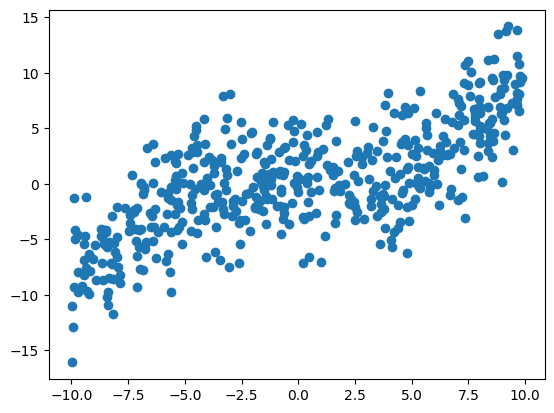

In [66]:
rng = np.random.default_rng(seed = 123)
n = 500
effect = 0.5
t_proportion = 0.5
x = rng.uniform(low=-10, high=10, size = (n,))
t = rng.binomial(n=1, p=t_proportion, size=(n,))
xt = (x**2/20-0.2)*(x/5)
y = effect*t + xt + rng.normal(scale = 3, size=(n,))
plt.scatter(x, y)

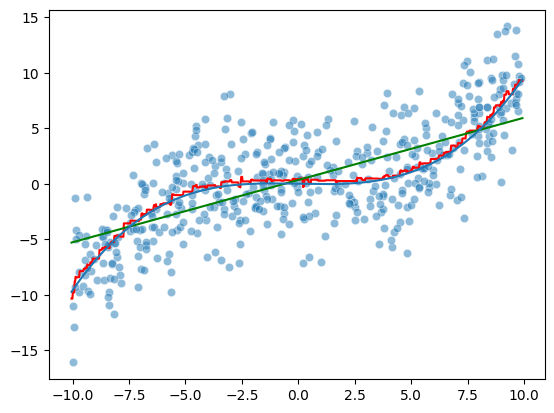

In [73]:
data = nonlinear_generator(x_coef=1)

g = GradientBoostingRegressor().fit(data[['X']].to_numpy(), data['Y'].to_numpy())
reg = LinearRegression().fit(data[['X']].to_numpy(), data['Y'].to_numpy())

xgrid = np.linspace(
    start = np.min(data['X'])-0.05,
    stop = np.max(data['X']+0.05),
    num=1000).reshape(-1,1)

gpreds = g.predict(xgrid)
rpreds = reg.predict(xgrid)

sns.scatterplot(x=x, y=y, alpha=0.5)
plt.plot(xgrid, gpreds, color='red')
plt.plot(xgrid, rpreds, color='green')
plt.plot(xgrid, (xgrid**2/20-0.2)*(xgrid/5))

In [74]:
kf = KFold(
    n_splits = 2, 
    shuffle=True,
    random_state = 123)
kf.get_n_splits(data)
estimates = []
sd = []
for i, (train_idx, test_idx) in enumerate(kf.split(data)):
    train = data.loc[train_idx]
    test = data.loc[test_idx]
    g = GradientBoostingRegressor().fit(train[['X']].to_numpy(), train['Y'].to_numpy())
    gpreds = g.predict(test[['X']].to_numpy())
    test["G"] = gpreds
    test["G_centered"] = gpreds - np.mean(gpreds)

    reg = smf.ols(
        "Y ~ T + G + T:G_centered",
        data = test
    ).fit(cov_type="HC2")
    estimates.append(reg.params['T'])
    sd.append(reg.bse['T'])

print(estimates)
print(sd)

[0.4860180481138415, 0.4517676507753383]
[0.058477769712555326, 0.06297333213625693]


In [75]:
reg = smf.ols(
    "Y ~ X + T + X_centered:T",
    data = data
).fit(cov_type='HC2')
reg.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
No. Observations:                 500   F-statistic:                     505.8
Covariance Type:                  HC2   Prob (F-statistic):          1.98e-150
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0309      0.103     -0.301      0.763      -0.232       0.170
X                0.5526      0.021     25.940      0.000       0.511       0.594
T                0.7155      0.139      5.135      0.000       0.442       0.989
X_centered:T     0.0127      0.029      0.438      0.661      -0.044       0.070
================================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [86]:
est = []
for i in range(1000):
    seed = rng.integers(low=0, high = 100000)
    data_trial = nonlinear_generator(
        seed=seed,
        x_coef = 30)
    reg = smf.ols(
        "Y ~ X + T + X_centered:T",
        data = data_trial
    ).fit(cov_type='HC2')
    est.append(reg.params['T'])

print(np.mean(est))
print(np.min(est), np.max(est))

0.4458469522354127
-12.84871866059152 11.88123910170074
